# Actity Recognition From RGB-D Images

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
import numpy as np
import lightnet as ln
import os
import xml.etree.cElementTree as ET
from fastai.vision import *
from fastai.metrics import error_rate

## Download Data

In [70]:
dataset_path = "/storage/UTKinect_Dataset"
folders = ["depth","rgb"]
label_fname = "actionLabel.txt"

In [147]:
def string_Arr_to_float(str_arr):
    """
    func: convert all string numbers in list to float
    param:  list of string numbers
    out:  list of float numbers
    """
    for x in range(len(str_arr)):
        try:
            str_arr[x] = float(str_arr[x])
    return str_arr

In [178]:
def depth_xml_to_arr(depthFilePath,beginFrm, endFrm, label):
    """
    func: load depth image data from given range of frames, and append label
    param: depthFilePath - path to file where frames are found
           beginFrm - first frame of activty 
           endFrm - last frame of activty
           label - label of activity
    out: list of touples contatining depth data of each frame between beginFrm and endFrm and label
    """
    xmlFiles = [f for f in os.listdir(depthFilePath) if f.endswith('.xml')]
    xmlFiles.sort(key=lambda item: (len(item), item))
    depthSequence = []
    
    beginFrmFile = "depthImg%i.xml" %beginFrm
    endFrmFile = "depthImg%i.xml" %endFrm
    
    beginIdx = xmlFiles.index(beginFrmFile)
    endIdx = xmlFiles.index(endFrmFile)
    useXmlFiles = xmlFiles[beginIdx:endIdx+1]
    
    for xmlFile in useXmlFiles:
        try:
            tree = ET.parse(os.path.join(depthFilePath, xmlFile))
            filename, _ = os.path.splitext(xmlFile)
            elem = tree.find('%s/data' % filename)
            strData = elem.text
            str_Arr = strData.split()
            floatData = string_Arr_to_float(str_Arr)
            arr = np.array(floatData)
            depthData = np.array(floatData).reshape(240, 320)
            depthSequence.append((depthData,label))
        except:
            print("Problem in: %s" %xmlFile)
    return depthSequence

In [179]:
def load_depth_imgs(depth_path,label_fname):
    """
    func: load depth image data from xml file
    param: depth_path - path to folder with depth data
           label_fname - name of the label txt file
    out: 
    """
    depth_data = []
    
    configFile = os.path.join(dataset_path, label_fname)
    with open(configFile, "r") as f:
        lines = f.read().splitlines()

    for i in range(0,220,11):
        currLines = lines[i:i+11]
        depthFileDir = currLines[0]

        print("loading %s" %depthFileDir)
        for line in currLines[1:]:
                splitIdx = line.index(":")
                label = line[:splitIdx]
                nums = line[splitIdx+1:].split()
                beginFrm = int(nums[0])
                endFrm = int(nums[1])
                depthFilePath = os.path.join(depth_path,depthFileDir)
                depth_data.extend(depth_xml_to_arr(depthFilePath,beginFrm, endFrm, label))
        
    return depth_data

In [180]:
depth_path = os.path.join(dataset_path, folders[0]); depth_path

'/storage/UTKinect_Dataset/depth'

In [181]:
depth_data_arr=load_depth_imgs(depth_path,label_fname)

loading s01_e01
loading s01_e02
loading s02_e01
loading s02_e02
loading s03_e01
loading s03_e02
loading s04_e01
loading s04_e02
loading s05_e01
loading s05_e02
loading s06_e01
loading s06_e02
loading s07_e01
depthImg4068.xml
depthImg4074.xml
depthImg4080.xml
depthImg4084.xml
depthImg4090.xml
depthImg4096.xml
depthImg4102.xml
depthImg4108.xml
depthImg4112.xml
depthImg4116.xml
depthImg4124.xml
depthImg4128.xml
loading s07_e02


FileNotFoundError: [Errno 2] No such file or directory: '/storage/UTKinect_Dataset/depth/s07_e02'

In [182]:
len(depth_data_arr)

0

## Load Images 

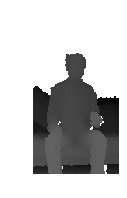

## Load Model

In [30]:
model = ln.models.YoloFusion()
bs = 64 # edit param if memory problems